In [1]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import rfft, irfft, fftfreq
import os
 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import scipy as sp
from scipy import signal


import itertools

%matplotlib inline

In [2]:
HOME = "/Users/jonat/OneDrive/Documents/Protocolo_PKS/Protocolo_PKS/dados_edf/DB_REPO/edf/"
def dadosPK(tipo):
    dir_ct = HOME+tipo+"/"
    return os.listdir(HOME+tipo+"/")

In [3]:
def carregarDataFrame(tipo, caminho):
    caminho = HOME+tipo+"/"+caminho
    
    edf = pyedflib.EdfReader(caminho)
    n = edf.signals_in_file
    sigbufs = np.zeros((n, edf.getNSamples()[0]))
    for i in np.arange(n):
         sigbufs[i, :] = edf.readSignal(i)
    edf._close()
    del edf

    return pd.DataFrame(data=sigbufs.T, columns=['ch1', 'ch2', 'ch3', 'ch4'])

def plotarFFT(a, b, titulo):
    plt.title(titulo)
    plt.plot(b,a)
    plt.xlim([0,500])
    plt.ylim([0,5000])
    plt.show
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão sobre diabetes',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Esperado')
    plt.xlabel('Obtido')
    
def frequecia(df, canal):
    sinalFFT = [fft(data, canal)[0] for data in df]
    return sinalFFT

def frequeciaFiltrada(df):
    sinalFFT = [fft(data) for data in df]
    return sinalFFT

def fft(df, canal):
    amostras = int(df[canal][2000:11000].shape[0]*500/2000)
    sinal = np.abs(np.fft.fft(df[canal][2000:11000]))[:amostras]
    freq = np.linspace(0,500,amostras)
    return (sinal,freq)

def fftFiltrada(df):
    amostras = int(df.shape[0]*500/2000)
    sinal = np.abs(np.fft.fft(df))[:amostras]
    freq = np.linspace(0,500,amostras)
    return (sinal,freq)

def plotarMatriz(y_teste, y_pred, canal):
    # Matriz de confusão
    print("Canal: "+canal)
    cnf_matrix = confusion_matrix(y_teste, y_pred )
    np.set_printoptions(precision=2)
    # Sem normalização
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=nomes, title='Matriz de confusão: '+canal)
    print(classification_report(y_pred, y_teste))

In [4]:
def filtrarEmg(emg, sfreq=1000, high_band=20, low_band=450):
    """
    time: Time data
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    emg = emg[2000:11000]
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    return sp.signal.filtfilt(b1, a1, emg)    

In [5]:
df_ct = [ carregarDataFrame('controle', nome) for nome in dadosPK('controle')]
df_pk = [ carregarDataFrame('parkinson', nome) for nome in dadosPK('parkinson')]

In [6]:
ctFiltrado = filtrarEmg(df_ct[0]['ch1'])
pkFiltrado = filtrarEmg(df_pk[0]['ch1'])

In [7]:
sinalCTFFT = fftFiltrada(ctFiltrado)
sinalPKFFT = fftFiltrada(pkFiltrado)

In [8]:
rotulosCT = [0 for _ in range(len(sinalCTFFT[0]))]
rotulosPK = [1 for _ in range(len(sinalPKFFT[0]))]

trainData =  pd.DataFrame(data=np.append(sinalPKFFT[0] , sinalCTFFT[0]))
rotulos = rotulosPK + rotulosCT

nomes = ['parkinson', 'controle']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(trainData, rotulos, test_size=0.3)
#trainCH1, trainCH2, trainCH3, trainCH4 = [train_test_split(train, rotulos, test_size=0.3) for train in trainData]

In [20]:
X_test

,0
627,500.743330
2550,63.845433
3650,449.808376
2688,112.325876
1465,1046.430069
1587,270.917644
3812,555.228478
1545,450.477317
1966,614.681602
262,657.224533


In [10]:
param_grid = [
  {'C': [1, 10], 'gamma': [0.001, 0.01], 'kernel': ['sigmoid']}
 # {'C': [1, 10], 'gamma': [0.001, 0.01], 'kernel':['poly'], 'degree':[3,4]}
 ]

In [11]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

In [12]:
grid.fit(X_train, y_train)
print(grid.score(X_test, y_teste))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV]  C=1, gamma=0.001, kernel=sigmoid, score=0.4719314938154139, total=   0.0s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  C=1, gamma=0.001, kernel=sigmoid, score=0.47523809523809524, total=   0.0s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV]  C=1, gamma=0.001, kernel=sigmoid, score=0.47950428979980936, total=   0.0s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV]  C=1, gamma=0.01, kernel=sigmoid, score=0.5042816365366318, total=   0.0s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV]  C=1, gamma=0.01, kernel=sigmoid, score=0.5047619047619047, total=   0.0s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV]  C=1, gamma=0.01, kernel=sigmoid, score=0.5042897998093422, total=   0.0s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.5023786869647955, total=   0.0s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.5247619047619048, total=   0.0s
[CV] C=10, ga

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.3s finished


NameError: name 'y_teste' is not defined

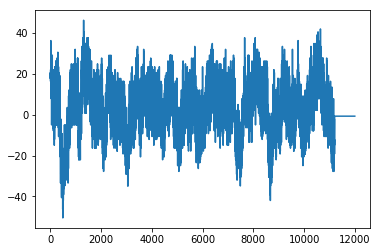

In [18]:
plt.plot(df_ct[0]['ch1'])